In [3]:

pip install -U kaleido



SyntaxError: invalid syntax (61183946.py, line 1)

In [1]:
import os
import sys
import kaleido
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')


ModuleNotFoundError: No module named 'kaleido'

In [6]:
# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout

style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [7]:
def ode_model(z, t, T, symp_T, c_3, p_trans, p_symp):
    
    """
    Values: 
    X=Susceptible, uninfected population
    S_t=syptomatic, tested regularly and uniformly (such as every 3 months etc)
    A_t=asymptomatic, tested regularly and uniformly
    N= the total population. We assume it is a fixed pool of gay, sexually active men, uniformly mixed.
    
    LATER (MAYBE):
    S_u= symptomatic, not tested regularly (likley to get tested ASAP after onset of symptoms)
    A_u= asymptomatic, untested. This group would act like a pool of cariers.

    
    Some parameters: 
    c_1=recovery rate of people who are symptomatic (per day)
    c_2=recovery rate of asymptomatic people (per day)
    c_3=average number of sexual partners per day per person (per day)
    p_trans=probability of transmission for a single pairing (no units)
    p_symp=probability that a contracted case is symptomatic (no units)
    p_asymp=probability that a contracted case is asymptomatic (no units)
    T=test result time
    symp_T = average onset of symptoms for symptomatic infections

    Relationship: Assume that without symptoms, we get tested every 90 days. Assume treatment takes 7 days. 
                  Recovery rate=1/recovery time. If we assume symptomatic people get tested as soon as they notice 
                  symptoms, then c_1=1/(symp_t+T+7) and c_2=1/(30+T+7)
                  
                  Note that 1=p_symp+p_asymp
    
    REMARKS: c_1 and c_2 are the key parameters here, since testing with faster results should increase the average 
             recovery rates (i.e. shorter recovery time)
             
             It might also make more sense to have an "Exposed" compartment that accounts for the latency period. 
    
    ASSUMPTION: We assume that the infected/non-infected population is uniformly mixed, and that the probability
                of a pairing between any of the compartments is uniform. This is not really realistic, because 
                it is likely that symptomatic people with remain abstinant until their treatment is over. 
                In our simplified setting, we will not assume that, but it can be adjusted later. We assume that in
                a group of N sexually active gay men, there is c_3*N (people per day who have had a sexual interaction)
                many interactons per day. We will assume that 
                there is no flow between compartments in an uninfected individual is paired 
                with an uninfected individual or if an infected individual is paired with another infected individual 
                (this is maybe another subtle simplification, since presumably an infected individual can be infected 
                with multiple strains.) Given that the total pairings per day is c_3*N, the number of pairings that could 
                lead to flow between compartments is just c_3*((S_t+A_t)/N)*X (the number of sexual interactions per day 
                that could result in an infection). NB: This term is a little fishy and I think we should rethink it. 
                
                We also assume that recovered individuals are immediately susceptible again. 
    """
    
    c_1=1/(symp_T+T) #symp_T = 3 - 5 days on average. 
    c_2=2/(21+T) #this is not realistic. Most people will clear in 2 weeks to 30 days (50 - 90% chance of clearing on your own.)
    p_asymp=1-p_symp
    
    #Remark: 10% probability of disseminated symptoms. 
    
    X, S_t, A_t = z
    N = X+S_t+A_t 
    dXdt = c_1*S_t + c_2*A_t - c_3*(A_t/N)*X*p_trans #note the simplification using the fact that p_symp+p_asymp=1
    dS_tdt = -c_1*S_t + c_3*(A_t/N)*X*p_trans*p_symp
    dA_tdt = -c_2*A_t + c_3*(A_t/N)*X*p_trans*p_asymp
    return [dXdt, dS_tdt, dA_tdt]

In [8]:
def ode_solver(t, initial_conditions, params):
    initA_t, initS_t, initN = initial_conditions
    T, symp_T, c_3, p_trans, p_symp = params
    initX = initN - (initS_t + initA_t)
    res = odeint(ode_model, [initX, initS_t, initA_t], t, args=(T, symp_T, c_3, p_trans, p_symp))
    return res


In [32]:

initN = 30000 #Initial total Population, N
# so initX=initN - initS_t - initA_t
initS_t = 250
initA_t = 250

T=5
symp_T=3
c_3=2/7 #this assumes 2 partners per week... probably higher in some populations. 
p_trans=0.5
p_symp=0.75
days = 100000

In [33]:
def main(initS_t, initA_t, initN, T, symp_T, c_3, p_trans, p_symp, days):
    initial_conditions = [initS_t, initA_t, initN]
    params = [T, symp_T, c_3, p_trans, p_symp]
    tspan = np.arange(100, days, 1)
    sol = ode_solver(tspan, initial_conditions, params)
    X,S_t, A_t = sol[:, 0], sol[:, 1], sol[:, 2]
    
    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tspan, y=X, mode='lines+markers', name='Susceptible'))
    fig.add_trace(go.Scatter(x=tspan, y=S_t, mode='lines+markers', name='Symptomatic Infected'))
    fig.add_trace(go.Scatter(x=tspan, y=A_t, mode='lines+markers', name='Asymptoatic Infected'))

    
    if days <= 30:
        step = 1
    elif days <= 90:
        step = 7
    else:
        step = 30
    
    # Edit the layout
    fig.update_layout(title='Simulation',
                       xaxis_title='Day',
                       yaxis_title='Counts',
                       title_x=0.5,
                      width=900, height=600
                     )
    fig.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(50, days + 1, step))
    if not os.path.exists("images"):
        os.mkdir("images")
    fig.write_image("images/seir_simulation.png")
    fig.show()
    
    return(sol[-1, 0], sol[-1, 1], sol[-1, 2])

def main_noplot(initS_t, initA_t, initN, T, symp_T, c_3, p_trans, p_symp, days):
    initial_conditions = [initS_t, initA_t, initN]
    params = [T, symp_T, c_3, p_trans, p_symp]
    tspan = np.arange(100, days, 1)
    sol = ode_solver(tspan, initial_conditions, params)
    X,S_t, A_t = sol[:, 0], sol[:, 1], sol[:, 2]
    
    return(sol[-1, 0], sol[-1, 1], sol[-1, 2])

In [34]:
interact(main, initS_t=IntSlider(min=0, max=1000000, step=1, value=initS_t, description='initS_t', style=style, layout=slider_layout),
               initA_t=IntSlider(min=0, max=1000000, step=10, value=initA_t, description='initA_t', style=style, layout=slider_layout),
               initN=IntSlider(min=0, max=1000000, step=1000, value=initN, description='initN', style=style, layout=slider_layout),
               T=FloatSlider(min=1, max=10, step=1, value=T, description='Restult Time', style=style, layout=slider_layout),
               symp_T=FloatSlider(min=0, max=20, step=1, value=symp_T, description='Average Days Until Symptoms', style=style, layout=slider_layout),
               c_3=FloatSlider(min=0, max=4, step=0.01, value=c_3, description='Partners per day', style=style, layout=slider_layout),
               p_trans=FloatSlider(min=0,max=1,steps=0.01, value=p_trans, description='Transmission probability', style=style, layout=slider_layout),
               p_symp=FloatSlider(min=0,max=1,steps=0.01, value=p_symp, description='Probability of Symptomatic Infection', style=style, layout=slider_layout), 
               days=IntSlider(min=200, max=800, step=7, value=days, description='Days', style=style, layout=slider_layout)
        );

interactive(children=(IntSlider(value=250, description='initS_t', layout=Layout(width='99%'), max=1000000, sty…

In [35]:
main_noplot(initS_t, initA_t, initN, T, symp_T, c_3, p_trans, p_symp, days)

(30000.00000000001, -4.1224246254944235e-24, -3.1741729616583056e-24)

In [36]:
steady_state_by_result_time=[main_noplot(initS_t, initA_t, initN, T, symp_T, c_3, p_trans, p_symp, days)[1]
                             +main_noplot(initS_t, initA_t, initN, T, symp_T, c_3, p_trans, p_symp, days)[2] for T in range(1,14)]

steady_state_by_result_time_Symp=[main_noplot(initS_t, initA_t, initN, T, symp_T, c_3, p_trans, p_symp, days)[1] for T in range(1,14)]

steady_state_by_result_time_Asymp=[main_noplot(initS_t, initA_t, initN, T, symp_T, c_3, p_trans, p_symp, days)[2] for T in range(1,14)]


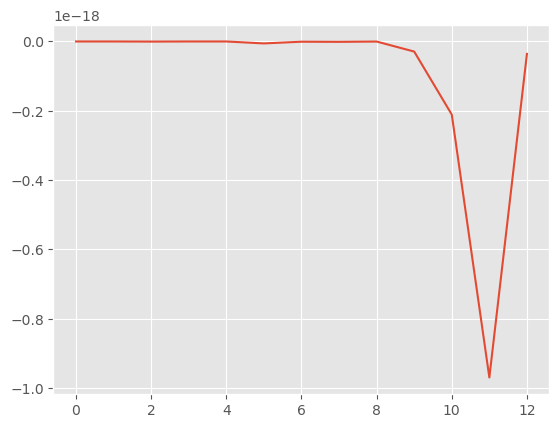

In [37]:
plt.plot(steady_state_by_result_time)

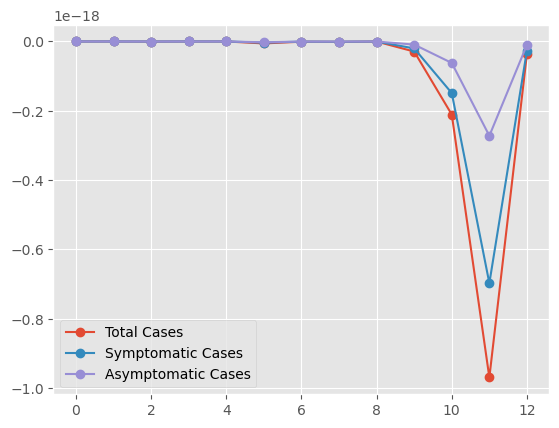

In [38]:
# Plotting the lists
plt.plot(steady_state_by_result_time, label='Total Cases', marker='o')
plt.plot(steady_state_by_result_time_Symp, label='Symptomatic Cases', marker='o')
plt.plot(steady_state_by_result_time_Asymp, label='Asymptomatic Cases', marker='o')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

In [15]:
steady_state_by_result_time=np.abs(np.round(steady_state_by_result_time))
steady_state_by_result_time_Symp=np.abs(np.round(steady_state_by_result_time_Symp))
steady_state_by_result_time_Asymp=np.abs(np.round(steady_state_by_result_time_Asymp))

In [24]:


#Testing_Cost(per test)
cost_test=1.80

#Treatment_Cost(per treatment)
cost_treatment=41.95

#Assuming everyone tested every three months: 
total_testing_cost=initN*4*cost_test
print("Total yearly testing cost:", total_testing_cost)


Total yearly testing cost: 216000.0


In [ ]:


# Plotting the lists
plt.plot(list1, label='List 1', marker='o')
plt.plot(list2, label='List 2', marker='o')
plt.plot(list3, label='List 3', marker='o')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

In [1]:
def f(x): 
    return x**2 - 3 +1/x


test=[0.1,0.5,0.75, 1, 1.1, 1.5, 1.75]

In [5]:
list(map(f,test))

[7.01,
 -0.75,
 -1.1041666666666667,
 -1.0,
 -0.8809090909090908,
 -0.08333333333333337,
 0.6339285714285714]